# Bayesian analysis of the empirical saturation point (refactored version)

In [55]:
from modules.DataSets import GenericDataSet, NormDistDataSet, KernelDensityEstimate
from modules.EftPredictions import *
from modules.StatisticalModel import StatisticalModel
import matplotlib.backends.backend_pdf
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Set location where pdf output will be stored.

In [3]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Constraints from density functional theory: data management

In [4]:
dft_constraints = {
    "Dutra_skyrme": GenericDataSet(filenames=["satpoints_dutra_skyrme.csv"]),
    "Kortelainen": GenericDataSet(filenames=["satpoints_kortelainen.csv"]),
    "Brown": GenericDataSet(filenames=["brown/satpoints_brown.csv"]),
    "Dutra_rmf": GenericDataSet(filenames=["satpoints_rmf_dutra_2014.csv"]),
    "FSU": NormDistDataSet(set_specifier="fsu_rmf"),
    "Schunck": KernelDensityEstimate(set_specifier="schunck")
}
# now add the saturation box from Drischler et al. (2016)
drischler = dft_constraints["Dutra_skyrme"] + dft_constraints["Kortelainen"]

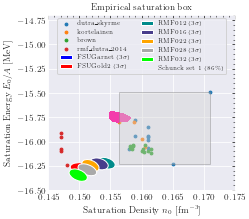

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 1.2*6.8*cm))
for key, val in dft_constraints.items():
    val.plot(ax=ax)
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 41 seconds.


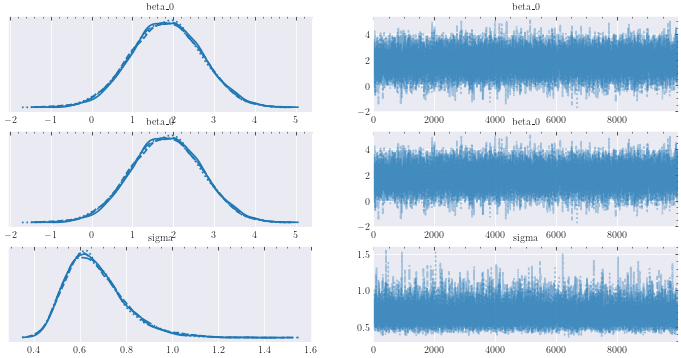

In [6]:
eft_pred = EftPredictions()
eft_pred.corner_plot()
eft_pred.plot(ax=ax)

In [7]:
fig.savefig(f"{pdf_path}/refactored_overview.pdf")

## Single universe as a test case

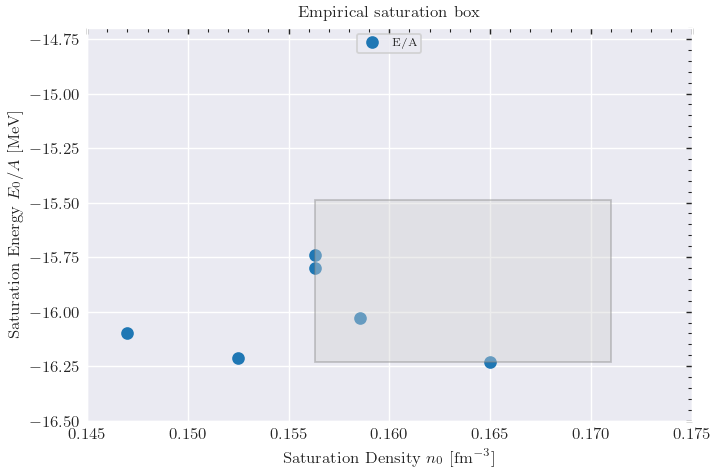

In [36]:
sampled_dft_constraints = pd.DataFrame()
for key, val in dft_constraints.items():
    sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

In [9]:
sampled_dft_constraints  # one realization (aka "universe") for testing

,label,rho0,E/A,class,file
6,SkT2,0.161000,-15.940000,dutra_skyrme,satpoints_dutra_skyrme.csv
2,UNEDF1,0.158710,-15.800000,kortelainen,satpoints_kortelainen.csv
7,brown:8,0.158610,-16.045170,brown,brown/satpoints_brown.csv
2,BSR11,0.147000,-16.080000,rmf_dutra_2014,satpoints_rmf_dutra_2014.csv
0,FSUGarnet,0.153462,-16.234356,fsu_rmf,data/Piekarewicz/FSUGarnet/CovEllipse.com
4417,schunck:2,0.155761,-15.729342,schunck:2,data/Schunck/samples2.csv


In [10]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}  # TODO: this prior is way too uninformed for the "true" nuclear saturation point. Make it realistic.
spoint = StatisticalModel(data=sampled_dft_constraints,
                          quantities=["rho0", "E/A"],
                          prior_params=prior_params)
spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)

sanity check based on predictive 'prior'
quantiles conj. prior: [[  0.14083185 -16.51883769]
 [  0.15994748 -15.89981349]
 [  0.1791173  -15.28510443]]
quantiles brute-force: [[  0.14089614 -16.51286139]
 [  0.15999843 -15.90023588]
 [  0.17914881 -15.27924468]]
passed: True


True

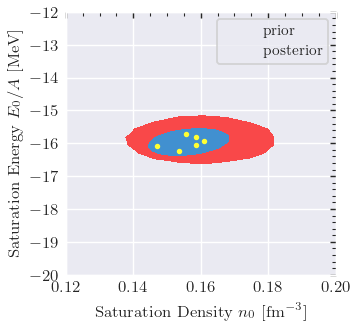

In [35]:
from modules.plot_helpers import *
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
spoint.plot(ax=ax, num_samples=500000)
fig.savefig(f"{pdf_path}/output.pdf")

## Multi-Universes
Now, let's average over different realizations ("universes").

Multi-universe sampling: 100%|██████████| 5/5 [02:58<00:00, 35.80s/it]


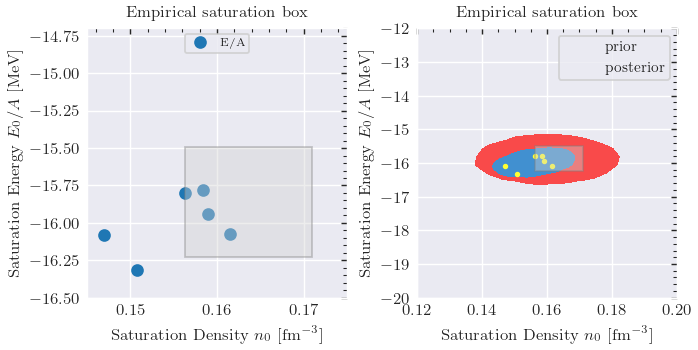

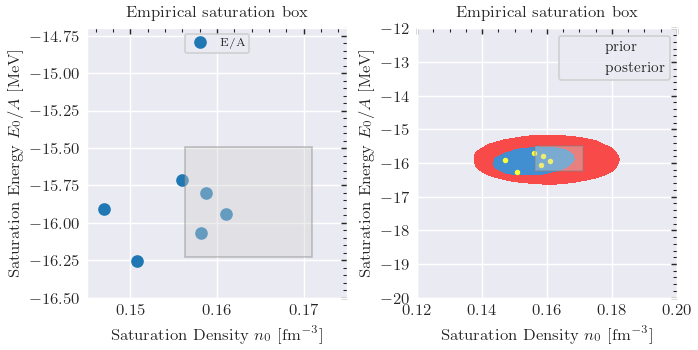

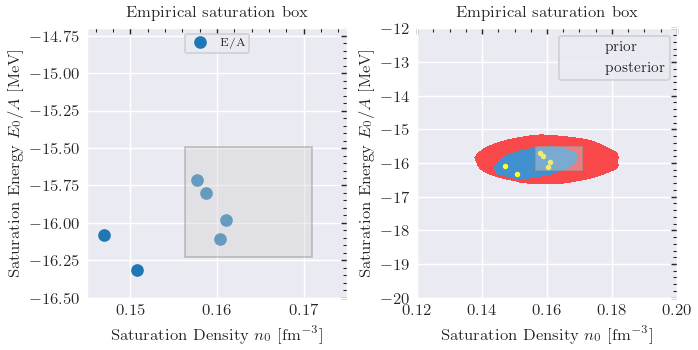

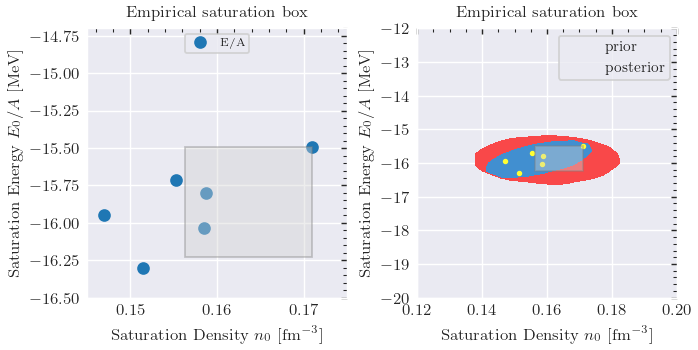

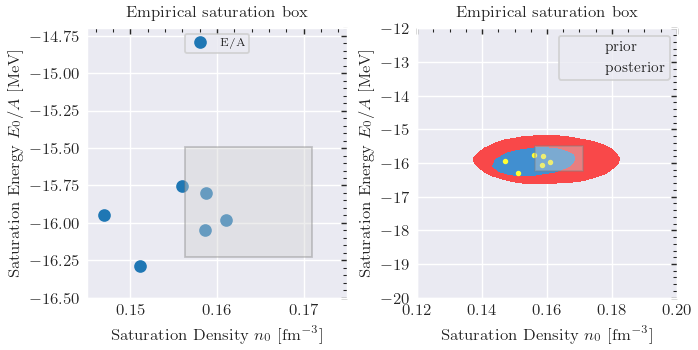

In [59]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/multi_universe_output.pdf")
num_realizations = 5

for irealiz in tqdm(range(num_realizations), desc="Multi-universe sampling"):
    # set up canvas
    fig, axs = plt.subplots(1, 2, figsize=(2*6.8*cm, 6.8*cm), constrained_layout=True)

    # construct data set ("universe") for Bayesian inference
    sampled_dft_constraints = pd.DataFrame()
    for key, val in dft_constraints.items():
        sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

    # plot raw data (left panel)
    sampled_dft_constraints.plot(ax=axs[0], x="rho0", y="E/A", linestyle="None", marker="o")
    for ax in axs:  # draw saturation box in both panels as a reference
        drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

    # perform Bayesian analysis
    spoint = StatisticalModel(data=sampled_dft_constraints,
                              quantities=["rho0", "E/A"],
                              prior_params=prior_params)
    #print(spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True))

    # plot predictive prior and predictive posterior (right panel)
    spoint.plot(ax=axs[1], num_samples=50000)
    pdf.savefig(fig)
pdf.close()

In [30]:
spoint.sample_predictive_bf(num_samples=1, num_samples_mu_Sigma=100000, return_predictive_only=False).mean(axis=0)

predictive rho0     0.156381
predictive E/A    -15.959859
mu rho0             0.156363
mu E/A            -15.961012
Sigma (0,0)         0.000035
Sigma (0,1)         0.000325
Sigma (1,1)         0.040268
dtype: float64

`num_samples_mu_Sigma` corresponds to Pablo's number of universes.